In [1]:
#conda install orbingol::geomdl

In [2]:
#conda install conda-forge::opencv

In [3]:
#conda install conda-forge::numpy-stl

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, RandomSampler
import os
import json
from matplotlib import pyplot as plt
import mask
import functional as fn
import visualization as vis
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd
import numpy as np

from PIL import Image
import torch.nn.functional as F
import re

# Constants

In [5]:
RUN_TYPE = 'train'

DEVICE = 'cuda'

L1 = 0.0025
L2 = 0.01
H_2 = 0.0005

MU = 3e-3
RHO = 1050
V_MAX = 0.3
P_MAX = 90.
Q = (V_MAX / 2) * 2 * H_2


N = 257
N_POINTS = 1000

METHOD = 'PINN'
USE_WEIGHT_OPT = False
N_NEURONS = 48#32
N_LAYERS = 15#10
SCHEDULER_GAMMA = 0.99
SCHEDULER_PATIENCE = 140
BATCH_SIZE = 6 #3
EPOCHS = 100000

N_INTERIOR = 500
N_WALLS = 250
N_INLET = 100
N_OUTLET = 100
N_BOUNDARY = N_WALLS + N_INLET + N_OUTLET

W_RES = 0.02
W_DIV = 0.02
W_V0 = 10000.
W_V_INLET = 1000. #1000.
W_P_OUTLET = 1.

if USE_WEIGHT_OPT:
    W_RES = torch.tensor(W_RES).to('cuda')
    W_RES.requires_grad_(True)
    W_DIV = torch.tensor(W_DIV).to('cuda')
    W_DIV.requires_grad_(True)
    W_V0 = torch.tensor(W_V0).to('cuda')
    W_V0.requires_grad_(True)
    W_V_INLET = torch.tensor(W_V_INLET).to('cuda')
    W_V_INLET.requires_grad_(True)
    W_P_OUTLET = torch.tensor(W_P_OUTLET).to('cuda')
    W_P_OUTLET.requires_grad_(True)

# NORM_IN_SUB = torch.tensor([0.75, 4., 0, 0]).reshape(1, 1, 4).to(DEVICE)
# NORM_IN_DIV = torch.tensor([0.33333, 1., 0.5 * L1, 0.5 * L2]).reshape(1, 1, 4).to(DEVICE)
NORM_OUT = torch.tensor([V_MAX, V_MAX, P_MAX]).reshape(1, 1, 3).to(DEVICE)

vis.set_params(12, L1, L2, 5)

LATENT_DIM = 3 #128
FINE_TUNE = False

# Dataset

In [ ]:
def sampler(x, n):
    ind = torch.randperm(len(x))[:n]
    return x[ind]


class ClassDataset(Dataset):
    def __init__(self, path, encoder):
        self.interior = []
        self.walls = []
        self.inlet = []
        self.outlet = []
        self.center = []
        self.h = []

        self.encoder = encoder

        files = os.listdir(path)

        # png_files = [f for f in os.listdir(path) if f.lower().endswith('.png')]
        # count = len(png_files)

        self.masks = torch.zeros(len(files), 1, N, N).float()
        self.embeding = torch.zeros(len(files), 3).float() #torch.zeros(len(files), 128).float() #torch.zeros(len(files), 2).float()

        for idx in range(len(files)):
            file_path = os.path.join(path, files[idx])
            if '.stl' in file_path:
                pass
                # mask_, x_interior, x_walls, x_inlet, x_outlet, center, h = mask.load_stl(file_path, N,
                #                                                             N_POINTS * N_INTERIOR,
                #                                                             N_POINTS * N_WALLS,
                #                                                             N_POINTS * N_INLET,
                #                                                             N_POINTS * N_OUTLET,
                #                                                             length=[L1, L1, L2],
                #                                                             device='cuda',
                #                                                             use_3d=False,
                #                                                             inside_buffer= 0.001)
                
                # self.interior.append(x_interior)
                # self.walls.append(x_walls)
                # self.inlet.append(x_inlet)
                # self.outlet.append(x_outlet)
                # self.center.append(torch.tensor(center).to(DEVICE))
                # self.h.append(torch.tensor(h).to(DEVICE))
                
                # self.masks[idx] = mask_['num']
                # self.embeding[idx, 0] = float(files[idx].split('_')[1].replace('-', '.'))
                # self.embeding[idx, 1] = float(files[idx].split('_')[3][0])
            else:
                mask_, x_interior, x_walls, x_inlet, x_outlet, center, h = mask.img_to_mask(file_path, N,
                                                                            N_POINTS * N_INTERIOR,
                                                                            N_POINTS * N_WALLS,
                                                                            N_POINTS * N_INLET,
                                                                            N_POINTS * N_OUTLET,
                                                                            length=[L1, L1, L2],
                                                                            device='cuda',
                                                                            use_3d=False,
                                                                            inside_buffer= 0.001)
                
                self.interior.append(x_interior)
                self.walls.append(x_walls)
                self.inlet.append(x_inlet)
                self.outlet.append(x_outlet)
                self.center.append(torch.tensor(center).to(DEVICE))
                self.h.append(torch.tensor(h).to(DEVICE))
                
                self.masks[idx] = mask_['num']
                
                ## self.embeding[idx, 0] = float(files[idx].split('_')[1].replace('-', '.'))
                ## self.embeding[idx, 1] = float(files[idx].split('_')[3][0])

                # img = Image.open(file_path)
                # img_array = np.array(img)
                # img_tensor = torch.from_numpy(img_array / 255.0).float().unsqueeze(0).unsqueeze(0).to(DEVICE)

                # with torch.no_grad():
                #     self.embeding[idx] = self.encoder(img_tensor)

                numbers = re.findall(r'idx_(\d+)_(\d+)_(\d+)\.png', files[idx])
                self.embeding[idx] = torch.tensor([int(n) for n in numbers[0]])

        self.sampler = sampler

    def __len__(self):
        return len(self.masks)

    def __getitem__(self, idx):
        x_interior = self.sampler(self.interior[idx], N_INTERIOR).to(DEVICE)

        emb_interior = self.embeding[idx].repeat(N_INTERIOR, 1).to(DEVICE)
        
        inputs_boundary = torch.cat((emb_interior[0].repeat(N_BOUNDARY, 1),
                                torch.cat((self.sampler(self.walls[idx], N_WALLS),
                                           self.sampler(self.inlet[idx], N_INLET),
                                           self.sampler(self.outlet[idx], N_OUTLET))).to(DEVICE)), 1)
        return emb_interior, x_interior, inputs_boundary, self.masks[idx], self.center[idx], self.h[idx]
        
def sample_boundarys(x):
    x_walls = x[:, :N_WALLS]
    x_inlet = x[:, N_WALLS:N_WALLS + N_INLET]
    x_outlet = x[:, N_WALLS + N_INLET:N_WALLS + N_INLET + N_OUTLET]

    return x_walls, x_inlet, x_outlet


def sample_v_inlet(inputs, center, h):
    with torch.no_grad():
        v_inlet_2 = (-((inputs[..., -2] - center) / - h) ** 2 + 1) * (2 * Q / (2 * h))
        v_inlet_1 = torch.zeros_like(v_inlet_2)
    return torch.stack((v_inlet_1, v_inlet_2), 2)


# ANN

## CAE

In [7]:
class Encoder(nn.Module):
    """Convolutional encoder network for CAE.
    Args:
        latent_dim (int): Dimension of latent space representation
    """
    def __init__(self, latent_dim=64):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            # (1, 460, 648) -> (16, 230, 324)
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            
            # (16, 230, 324) -> (32, 115, 162)
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            
            # (32, 115, 162) -> (64, 58, 81)
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            
            # (64, 58, 81) -> (128, 29, 41)
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0),
            nn.ReLU()
        )
        
        self._calculate_fc_input(latent_dim)
    
    def _calculate_fc_input(self, latent_dim):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 460, 648)
            dummy_output = self.conv_layers(dummy_input)
            self.fc_input_dim = dummy_output.numel() // dummy_output.shape[0]
            self.fc = nn.Linear(self.fc_input_dim, latent_dim)
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class Decoder(nn.Module):
    """Convolutional decoder network for CAE.
    Args:
        latent_dim (int): Dimension of latent space representation
    """
    def __init__(self, latent_dim=64):
        super().__init__()
  
        self.fc_output_dim = 128 * 29 * 41
        self.fc = nn.Linear(latent_dim, self.fc_output_dim)
        
        self.deconv_layers = nn.Sequential(
            nn.Unflatten(1, (128, 29, 41)),
            
            # (128, 29, 41) -> (64, 58, 82)
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            
            # (64, 58, 82) -> (32, 116, 164)
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            
            # (32, 116, 164) -> (16, 232, 328)
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            
            # (16, 232, 328) -> (1, 460, 648)
            nn.ConvTranspose2d(16, 1, kernel_size=5, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.fc(x)
        return self.deconv_layers(x)

class CAE(nn.Module):
    """Complete Convolutional Autoencoder architecture.
    Args:
        latent_dim (int): Dimension of latent space representation
    """
    def __init__(self, latent_dim=64):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        
        if reconstructed.shape[2:] != x.shape[2:]:
            reconstructed = F.interpolate(reconstructed, size=x.shape[2:], mode='bilinear')
        
        return reconstructed

In [ ]:
cae_model = CAE(latent_dim=128).to(DEVICE)
cae_model.load_state_dict(torch.load("models_cae/best_val_cae.pth"))
encoder = cae_model.encoder
encoder.eval()

Encoder(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU()
  )
  (fc): Linear(in_features=139776, out_features=128, bias=True)
)

In [9]:
numbers = re.findall(r'idx_(\d+)_(\d+)_(\d+)\.png', 'idx_1_1_50.png')
embedding = np.array([int(n) for n in numbers[0]])
embedding

array([ 1,  1, 50])

In [10]:
def calculate_latent_stats(dataset_path, encoder, device='cuda'):
    encoder.eval()
    latent_vectors = []
    
    files = os.listdir(dataset_path)

    for idx in range(len(files)):
        file_path = os.path.join(dataset_path, files[idx])
        if '.png' in file_path:

            # img = Image.open(file_path)
            # img_array = np.array(img)
            # img_tensor = torch.from_numpy(img_array / 255.0).float().unsqueeze(0).unsqueeze(0).to(DEVICE)

            # with torch.no_grad():
            #     embedding = encoder(img_tensor).cpu().numpy()
            #     latent_vectors.append(embedding)
            
            numbers = re.findall(r'idx_(\d+)_(\d+)_(\d+)\.png', files[idx])
            embedding = np.array([int(n) for n in numbers[0]])
            latent_vectors.append(embedding)

    latent_array = np.vstack(latent_vectors)
    #latent_array = np.concatenate(latent_vectors, axis=0)
    mean = latent_array.mean(axis=0).astype(np.float32)
    std = latent_array.std(axis=0).astype(np.float32)
    return mean, std

In [ ]:
emb_mean, emb_std = calculate_latent_stats('dataset/mini_train',encoder)
print(f'mean = {emb_mean}, \nstd = {emb_std}')

In [12]:
NORM_IN_SUB = torch.tensor(np.concatenate([emb_mean, np.array([0, 0])])).float().reshape(1, 1, LATENT_DIM+2).to(DEVICE)
NORM_IN_DIV = torch.tensor(np.concatenate([emb_std + 1e-8, np.array([0.5 * L1, 0.5 * L2])])).float().reshape(1, 1, LATENT_DIM+2).to(DEVICE)

## PINN

In [13]:
def create_layers(input_size, hidden_layer_size, hidden_layers, output_size):
    layers = []
    for i in range(hidden_layers):
        if not i:
            layers += [nn.Linear(input_size, hidden_layer_size, bias=True),
                       nn.SiLU(inplace=True)]
            torch.nn.init.xavier_normal_(layers[-2].weight)
        else:
            layers += [nn.Linear(hidden_layer_size, hidden_layer_size, bias=True),
                       nn.SiLU(inplace=True)]
            torch.nn.init.xavier_normal_(layers[-2].weight)
            
    layers.append(nn.Linear(hidden_layer_size, output_size, bias=True))
    torch.nn.init.xavier_normal_(layers[-1].weight)
    
    return layers


class MLP(nn.Module):
    def __init__(self, hyp):
        super(MLP, self).__init__()
        input_size = 5 #130 # 4
        
        output_size = 3 if METHOD == 'PINN' else 2
        self.mlp = []
        for i in range(output_size):
            layers = create_layers(input_size, hyp['hidden_layer_size'], hyp['hidden_layers'], 1)
            self.mlp.append(nn.Sequential(*layers))
        self.mlp1, self.mlp2, self.mlp3 = self.mlp
        self.output_size = output_size
    
    def forward(self, x):
        y = []
        for i in range(self.output_size):
            y.append(self.mlp[i]((x - NORM_IN_SUB) / NORM_IN_DIV) * NORM_OUT[..., i])
        return torch.cat(y, 2)

# Load train data

In [14]:
train_dataset = ClassDataset('dataset/mini_train', encoder)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Mask generation with path: dataset/mini_train\idx_1_1_50.png
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done


0.0006537478766404092
Mask generation with path: dataset/mini_train\idx_1_5_20.png
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done


0.0005877342191524804
Mask generation with path: dataset/mini_train\idx_1_5_40.png
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done


0.0005238500889390707
Mask generation with path: dataset/mini_train\idx_1_5_60.png
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done


0.0004620953986886889
Mask generation with path: dataset/mini_train\idx_1_5_80.png
done

Interior points generation
done

Walls points generation
done

Inlet points g

# Training

In [ ]:
if RUN_TYPE == 'train':
    best_loss = 1e10

    hyp = {'hidden_layer_size': N_NEURONS, 'hidden_layers': N_LAYERS}
    if FINE_TUNE:
        model = MLP(hyp).to(DEVICE)
        model.load_state_dict(torch.load(f'work/{METHOD}_{SCHEDULER_PATIENCE}.pth'))
        with open(f'work/{METHOD}_history_{SCHEDULER_PATIENCE}.json', 'r') as fp:
            losses = json.load(fp)
    else: 
        model = MLP(hyp).to(DEVICE)
        losses = {'residual_loss': [],
              'div(v)_loss': [],
              'ns_loss': [],
              'v_inlet_loss': [],
              'p_outlet_loss': [],
              'PINN_loss': [],
              'lr': []}

    if USE_WEIGHT_OPT:
        optimizer = torch.optim.Adam([{'params': model.parameters(), 'lr': 1e-3, 'weight_decay': 0.},
                                    {'params': [W_RES, W_DIV, W_V0, W_V_INLET, W_P_OUTLET], 'lr': 1e-3, 'weight_decay': 0.}],
                                    lr=1e-3, weight_decay=0.)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.)

    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=SCHEDULER_GAMMA)

    
    for i in range(EPOCHS):
        print(f"\rEpoch: {i+1}", end="", flush=True)
        n_iter = 0.

        losses['residual_loss'].append(0.)
        losses['div(v)_loss'].append(0.)
        losses['ns_loss'].append(0.)
        losses['v_inlet_loss'].append(0.)
        losses['p_outlet_loss'].append(0.)
        losses['PINN_loss'].append(0.)
        losses['lr'].append(0.)

        for emb_interior, x_interior, inputs_boundary, mask_, center, h in train_loader:
            optimizer.zero_grad()

            x_interior.requires_grad_(True)

            inputs_interior = torch.cat((emb_interior,
                                        x_interior), 2)
            
            outputs_interior = model(inputs_interior)

            outputs_walls, outputs_inlet, outputs_outlet = sample_boundarys(model(inputs_boundary))

            dv1, dv2, d2v1, d2v2, dp = fn.calc_grad(outputs_interior, x_interior)
            
            res_loss = fn.zero_loss(fn.calc_res(outputs_interior, dv1, dv2, d2v1, d2v2, dp, MU, RHO))
            div_loss = fn.mse_zero_loss(fn.calc_div(dv1, dv2))
            v0_loss = fn.mse_zero_loss(outputs_walls[..., :2])
            v_inlet_loss = torch.nn.functional.mse_loss(outputs_inlet[..., :2], sample_v_inlet(sample_boundarys(inputs_boundary)[1],
                                                                                               center.unsqueeze(1),
                                                                                               h.unsqueeze(1)))
            p_outlet_loss = fn.mse_zero_loss(outputs_outlet[..., 2])

            loss = W_RES * res_loss + W_DIV * div_loss + W_V0 * v0_loss + W_V_INLET * v_inlet_loss + W_P_OUTLET * p_outlet_loss
            loss.backward()

            losses['residual_loss'][-1] += (res_loss.item())
            losses['div(v)_loss'][-1] += (div_loss.item())
            losses['ns_loss'][-1] += (v0_loss.item())
            losses['v_inlet_loss'][-1] += (v_inlet_loss.item())
            losses['p_outlet_loss'][-1] += (p_outlet_loss.item())
            losses['PINN_loss'][-1] += (loss.item())
            losses['lr'][-1] += (lr_scheduler.get_last_lr()[0])

            n_iter += 1

            optimizer.step()


        losses['residual_loss'][-1] /= n_iter
        losses['div(v)_loss'][-1] /= n_iter
        losses['ns_loss'][-1] /= n_iter
        losses['v_inlet_loss'][-1] /= n_iter
        losses['p_outlet_loss'][-1] /= n_iter
        losses['PINN_loss'][-1] /= n_iter
        losses['lr'][-1] /= n_iter

        
        if losses['PINN_loss'][-1] < best_loss:
            best_loss = losses['PINN_loss'][-1]
            torch.save(model.state_dict(), f'work/{METHOD}_{SCHEDULER_PATIENCE}.pth')
            torch.save(optimizer.state_dict(), f'work/{METHOD}_opt_{SCHEDULER_PATIENCE}.pth')
            

        if (not i % 1000) and i:
            print(f'\nIteration {i + 1}')
            print('res_loss', losses['residual_loss'][-1])
            print('div(v)_loss', losses['div(v)_loss'][-1])
            print('ns_loss', losses['ns_loss'][-1])
            print('v_inlet_loss', losses['v_inlet_loss'][-1])
            print('p_outlet_loss', losses['p_outlet_loss'][-1])
            print('loss', losses['PINN_loss'][-1])
            print('lr', losses['lr'][-1])
            with open(f'work/{METHOD}_history_{SCHEDULER_PATIENCE}.json', 'w') as fp:
                json.dump(losses, fp)
            
            
        if (not i % SCHEDULER_PATIENCE):
            lr_scheduler.step()

    optimizer.zero_grad()
        
    del x_interior, inputs_interior, emb_interior, inputs_boundary, mask_
    del outputs_interior, outputs_walls, outputs_inlet, outputs_outlet
    del dv1, dv2, d2v1, d2v2, dp
    del res_loss, div_loss, v0_loss, v_inlet_loss, p_outlet_loss, loss


Epoch: 9

KeyboardInterrupt: 

# Save results

In [ ]:
if RUN_TYPE == 'train':
    torch.save(model.state_dict(), f'work/{METHOD}_{SCHEDULER_PATIENCE}.pth')
    torch.save(optimizer.state_dict(), f'work/{METHOD}_opt_{SCHEDULER_PATIENCE}.pth')
    with open(f'work/{METHOD}_history_{SCHEDULER_PATIENCE}.json', 'w') as fp:
        json.dump(losses, fp)


# Load saved model

In [ ]:
hyp = {'hidden_layer_size': N_NEURONS, 'hidden_layers': N_LAYERS}

model = MLP(hyp).to(DEVICE)
model.load_state_dict(torch.load(f'work/{METHOD}_{SCHEDULER_PATIENCE}.pth'))

with open(f'work/{METHOD}_history_{SCHEDULER_PATIENCE}.json', 'r') as fp:
    losses = json.load(fp)

# Plot training history

In [ ]:
for i in losses:
    print(i)

In [ ]:
vis.train_history_plot(losses)

In [ ]:
def my_train_history_plot(history, mode='Train'):
    """Plot train history.

    Args:
        history (dict): Dict of lists with train history.
    """

    for i in history:
        fig, ax = plt.subplots(figsize=(PARAMS['figsize'] * 2, PARAMS['figsize']))

        if mode == 'Train':
            ax.plot(history[i], c='r')
            ax.set_title(i)
            ax.set_xlabel('Epochs')
            ax.set_ylabel('lr' if i == 'lr' else 'Loss')
            ax.legend(['Train'])
            if min(history[i]) > 0:
                ax.set_yscale('log')
            plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
        else:
            ax.plot(history[i], c='b')
            ax.set_title(i)
            ax.set_xlabel('Epochs')
            ax.set_ylabel('lr' if i == 'lr' else 'Loss')
            ax.legend(['Val'])
            if min(history[i]) > 0:
                ax.set_yscale('log')
            plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
        plt.show()

In [ ]:
#vis.train_history_plot(val_losses, 'Val')

# Load test data

In [77]:
train_dataset = ClassDataset('dataset/mini_train',encoder)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

val_dataset = ClassDataset('dataset/mini_val',encoder)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

Mask generation with path: dataset/mini_train\idx_1_1_50.png
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done


0.0006537478766404092
Mask generation with path: dataset/mini_train\idx_1_5_20.png
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done


0.0005877342191524804
Mask generation with path: dataset/mini_train\idx_1_5_40.png
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done


0.0005238500889390707
Mask generation with path: dataset/mini_train\idx_1_5_60.png
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done


0.0004620953986886889
Mask generation with path: dataset/mini_train\idx_1_5_80.png
done

Interior points generation
done

Walls points generation
done

Inlet points g

# Visualize

In [ ]:
def visualization(loader, title):
    print(f'{title} visualization')
    count = 0
    with torch.no_grad():
        for emb_interior, x_interior, inputs_boundary, mask_, center, h in loader:
            x1 = torch.linspace(-L1 / 2, L1 / 2, N)
            x2 = torch.linspace(-L2 / 2, L2 / 2, N)
            x1, x2 = torch.meshgrid((x1, x2))
            x = torch.stack((x1.flatten(0), x2.flatten(0)), 1).to(DEVICE)

            inputs = torch.cat((emb_interior[0, 0].repeat(1, N * N, 1), x.to(DEVICE).unsqueeze(0)), 2)
            outputs = model(inputs)

            v1 = (outputs[..., 0].detach().cpu().reshape(N, N) * mask_[0])[0]
            v2 = (outputs[..., 1].detach().cpu().reshape(N, N) * mask_[0])[0]
            p = (outputs[..., 2].detach().cpu().reshape(N, N) * mask_[0])[0]

            print(f'ID1: {emb_interior[0][0][0].item()}, ID2: {emb_interior[0][0][1].item()}, weight: {emb_interior[0][0][2].item()}')
            print(f'v_abs: {np.sqrt((np.max(v1.numpy()))**2 + (np.max(v2.numpy()))**2)}')
            print(f'p_max: {np.max(p.numpy())}')

            vis.flow_visualization(v1, v2, x1, x2)
            vis.distribution_visualization(v1, 'v1, m/s (PINN)')
            vis.distribution_visualization(v2, 'v2, m/s (PINN)')
            vis.distribution_visualization(p, 'p, Pa (PINN)')

            count += 1


## Visualize train dataset

In [ ]:
visualization(train_loader, 'Train')

## Visualize val dataset

In [ ]:
visualization(val_loader, 'Train')

In [ ]:
plt.scatter(*train_dataset[2][1].T.cpu(), s=2)
plt.scatter(*train_dataset[2][2][:, 2:].T.cpu(), s=2)

In [ ]:
mini_dataset = ClassDataset('mini_dataset', encoder)

In [ ]:
loader = DataLoader(mini_dataset, batch_size=1, shuffle=True)

In [ ]:
plt.figure(figsize=(10,50))
i=1
for emb_interior, x_interior, inputs_boundary, mask_, center, h in loader:
    plt.subplot(11,1,i)
    plt.title(f"Latent Vector ({LATENT_DIM} dim)")
    latent_vector = emb_interior[0].cpu().numpy()
    colors = ['r' if v < 0 else 'b' for v in latent_vector[0]]
    plt.bar(range(LATENT_DIM), latent_vector[0], color=colors)
    plt.xlabel("Dimension Index")
    plt.ylabel("Value")
    plt.grid(True, alpha=0.3)
    i+=1

plt.show()

In [ ]:
plt.figure(figsize=(10,250))
img_features = np.zeros((128,11))
i=0
for emb_interior, x_interior, inputs_boundary, mask_, center, h in loader:
    latent_vector = emb_interior[0].cpu().numpy()
    img_features[:,i] = latent_vector[0]
    i+=1

for j in range(128):
    plt.subplot(128,1,j+1)
    plt.title(f"Feature interpolation (11 img)")
    colors = ['r' if v < 0 else 'b' for v in img_features[j]]
    plt.bar(range(11), img_features[j], color=colors)
    plt.xlabel("image")
    plt.ylabel("Value")
    plt.grid(True, alpha=0.3)
    i+=1

plt.show()

# Compare with CFD

In [27]:
def distribution_visualization_all(targets, outputs, errors, mask_, ref_1, ref_2, interp):
     v1_tar = (targets[..., 0].reshape(N, N)) * mask_
     v2_tar = (targets[..., 1].reshape(N, N)) * mask_
     p_tar = (targets[..., 2].reshape(N, N)) * mask_

     v1_pred = (outputs[..., 0].reshape(N, N)) * mask_
     v2_pred = (outputs[..., 1].reshape(N, N)) * mask_
     p_pred = (outputs[..., 2].reshape(N, N)) * mask_

     v1_err = (errors[..., 0].reshape(N, N)) * mask_
     v2_err = (errors[..., 1].reshape(N, N)) * mask_
     p_err = (errors[..., 2].reshape(N, N)) * mask_
     
     fig, ax = plt.subplots(figsize=(vis.PARAMS['figsize'] * 2, vis.PARAMS['figsize'] * 2), nrows=3, ncols=3)

     vis.imshow(fig, ax[0, 0], v1_tar * 100, vis.PARAMS['L1'] * 1000, vis.PARAMS['L2'] * 1000, r'$x_1, $mm', r'$x_2, $mm', r'$v_1^{CFD}, $cm/s')
     vis.imshow(fig, ax[0, 1], v1_pred * 100, vis.PARAMS['L1'] * 1000, vis.PARAMS['L2'] * 1000, r'$x_1, $mm', r'$x_2, $mm', r'$v_1^{PINN}, $cm/s')
     vis.imshow(fig, ax[0, 2], v1_err * 100, vis.PARAMS['L1'] * 1000, vis.PARAMS['L2'] * 1000, r'$x_1, $mm', r'$x_2, $mm', r'$v_1^{Error}, $cm/s')

     vis.imshow(fig, ax[1, 0], v2_tar * 100, vis.PARAMS['L1'] * 1000, vis.PARAMS['L2'] * 1000, r'$x_1, $mm', r'$x_2, $mm', r'$v_2^{CFD}, $cm/s')
     vis.imshow(fig, ax[1, 1], v2_pred * 100, vis.PARAMS['L1'] * 1000, vis.PARAMS['L2'] * 1000, r'$x_1, $mm', r'$x_2, $mm', r'$v_2^{PINN}, $cm/s')
     vis.imshow(fig, ax[1, 2], v2_err * 100, vis.PARAMS['L1'] * 1000, vis.PARAMS['L2'] * 1000, r'$x_1, $mm', r'$x_2, $mm', r'$v_2^{Error}, $cm/s')

     vis.imshow(fig, ax[2, 0], p_tar, vis.PARAMS['L1'] * 1000, vis.PARAMS['L2'] * 1000, r'$x_1, $mm', r'$x_2, $mm', r'$p^{CFD}, $Pa')
     vis.imshow(fig, ax[2, 1], p_pred, vis.PARAMS['L1'] * 1000, vis.PARAMS['L2'] * 1000, r'$x_1, $mm', r'$x_2, $mm', r'$p^{PINN}, $Pa')
     vis.imshow(fig, ax[2, 2], p_err, vis.PARAMS['L1'] * 1000, vis.PARAMS['L2'] * 1000, r'$x_1, $mm', r'$x_2, $mm', r'$p^{Error}, $Pa')

     plt.subplots_adjust(hspace=0.35, wspace=0.4)

     plt.savefig(f'{ref_1}_{ref_2}_{interp}.png', transparent=True)

     plt.show()

In [85]:
def visualization_compare(ref_1, ref_2, interp, inputs, targets, outputs, mask_):
    knn_tar = KNeighborsRegressor(3, weights='distance')
    knn_pred = KNeighborsRegressor(3, weights='distance')
    knn_err = KNeighborsRegressor(3, weights='distance')
    knn_tar.fit(inputs[:, 3:], targets)
    knn_pred.fit(inputs[:, 3:], outputs)
    knn_err.fit(inputs[:, 3:], outputs - targets)

    
    with torch.no_grad():
        x1 = torch.linspace(-L1 / 2, L1 / 2, N)
        x2 = torch.linspace(-L2 / 2, L2 / 2, N)
        x1, x2 = torch.meshgrid((x1, x2))
        x = torch.stack((x1.flatten(0), x2.flatten(0)), 1).to(DEVICE)
        emb = torch.tensor([ref_1, ref_2, interp]).to(DEVICE)
        inputs = torch.cat((emb.repeat(1, N * N, 1), x.to(DEVICE).unsqueeze(0)), 2)
        outputs = model(inputs)
        targets = knn_tar.predict(inputs.cpu().numpy()[0, :, 3:])
        outputs = knn_pred.predict(inputs.cpu().numpy()[0, :, 3:])
        errors = knn_err.predict(inputs.cpu().numpy()[0, :, 3:])

        v1_tar = (targets[..., 0].reshape(N, N)) * mask_
        v2_tar = (targets[..., 1].reshape(N, N)) * mask_
        v1_pred = (outputs[..., 0].reshape(N, N)) * mask_
        v2_pred = (outputs[..., 1].reshape(N, N)) * mask_
        plt.imshow(mask_)
        plt.show()
        vis.flow_visualization(v1_tar, v2_tar, x1, x2)
        vis.flow_visualization(v1_pred, v2_pred, x1, x2)

        distribution_visualization_all(targets, outputs, errors, mask_, ref_1, ref_2, interp)


In [86]:
def mae(targets, outputs, inputs):
    v_abs_tar = 100 * (targets[:, :2] ** 2).sum(1) ** 0.5
    v_abs_pred = 100 * (outputs[:, :2] ** 2).sum(1) ** 0.5

    p_tar = targets[:, -1]
    p_pred = outputs[:, -1]

    error_v = abs(v_abs_pred - v_abs_tar).mean()
    error_p = abs(outputs[:, -1] - targets[:, -1]).mean()

    mean_error_v = abs(v_abs_pred.mean() - v_abs_tar.mean()) / v_abs_tar.mean()
    mean_error_p = abs(p_pred.mean() - p_tar.mean()) / p_tar.mean()

    return error_v, mean_error_v * 100, v_abs_tar.max(), error_p, mean_error_p * 100, p_tar.max()

mini_train
1.0 1.0 50.0
error_v 12.08633490201475 mean_error_v 78.69545988754845 v_max 22.94440000008449 error_p 19.040137526465152 mean_error_p 118.99342677205757 p_max 33.83562


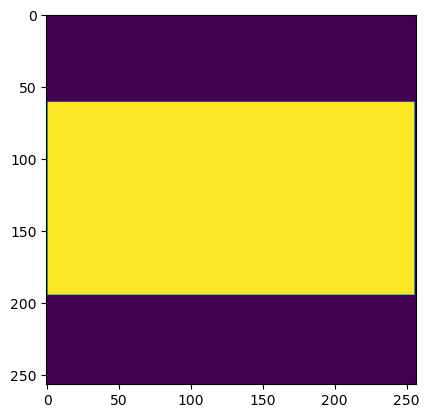

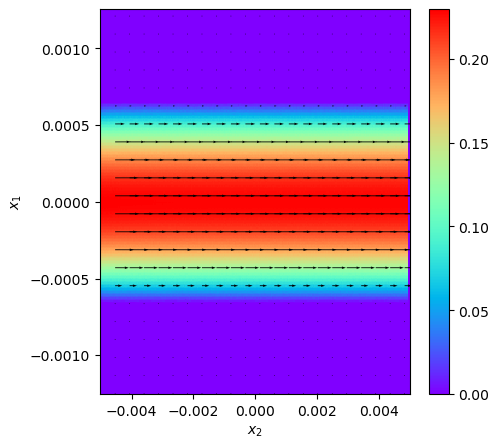

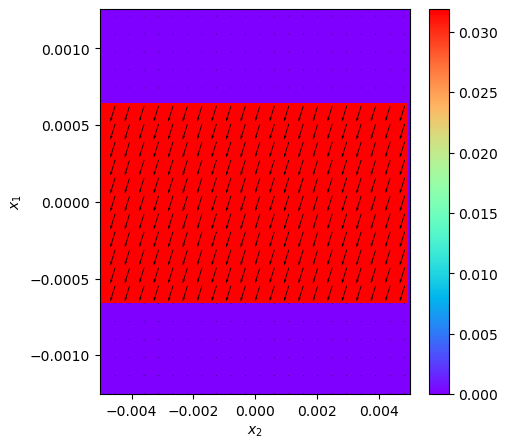

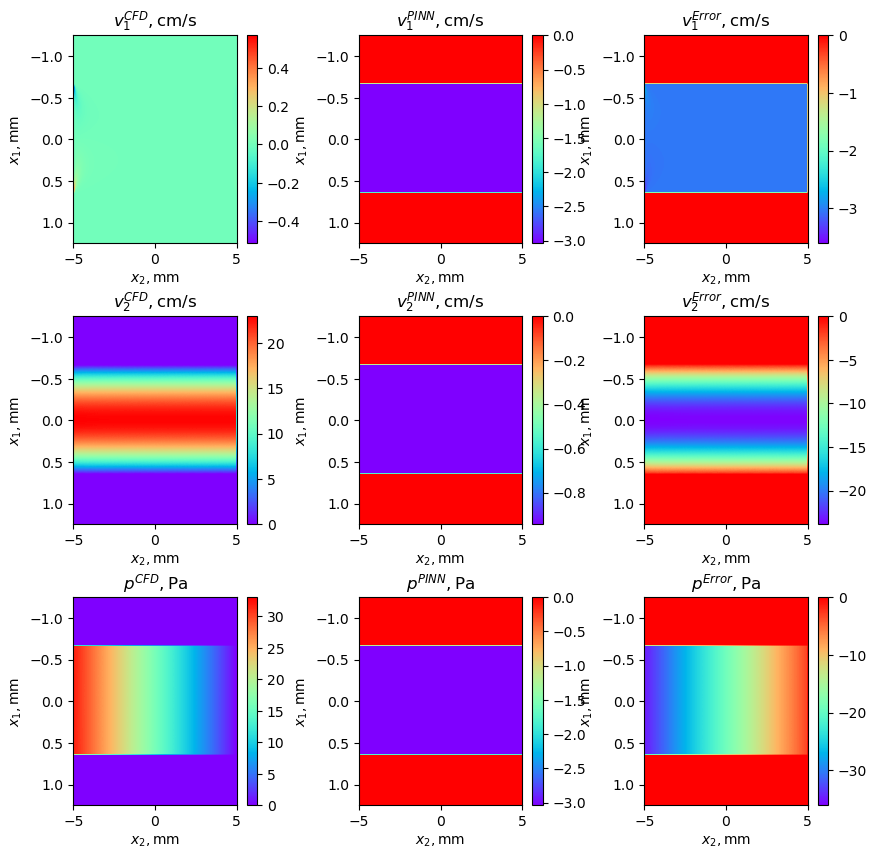

1.0 5.0 20.0
error_v 12.849528213373532 mean_error_v 79.74138578971822 v_max 25.5214 error_p 24.304331639100152 mean_error_p 114.28531632806845 p_max 40.042275000000004


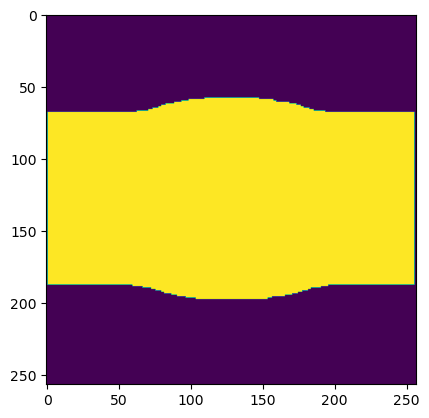

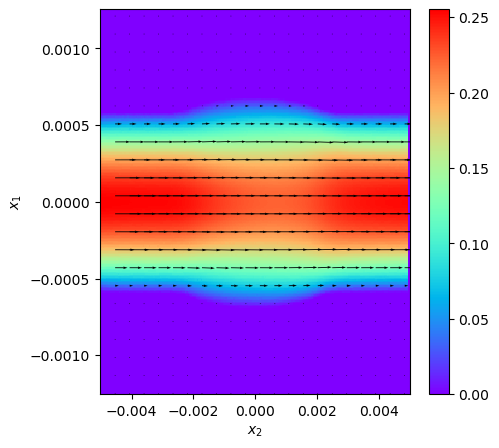

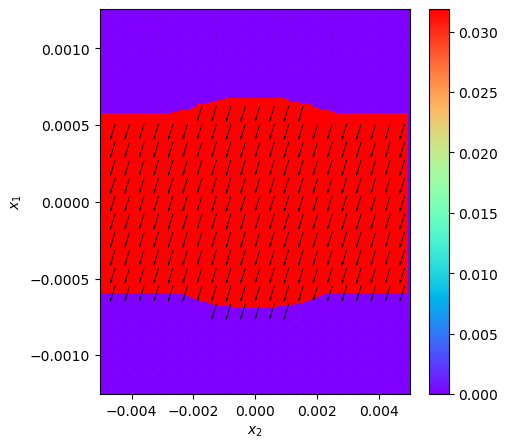

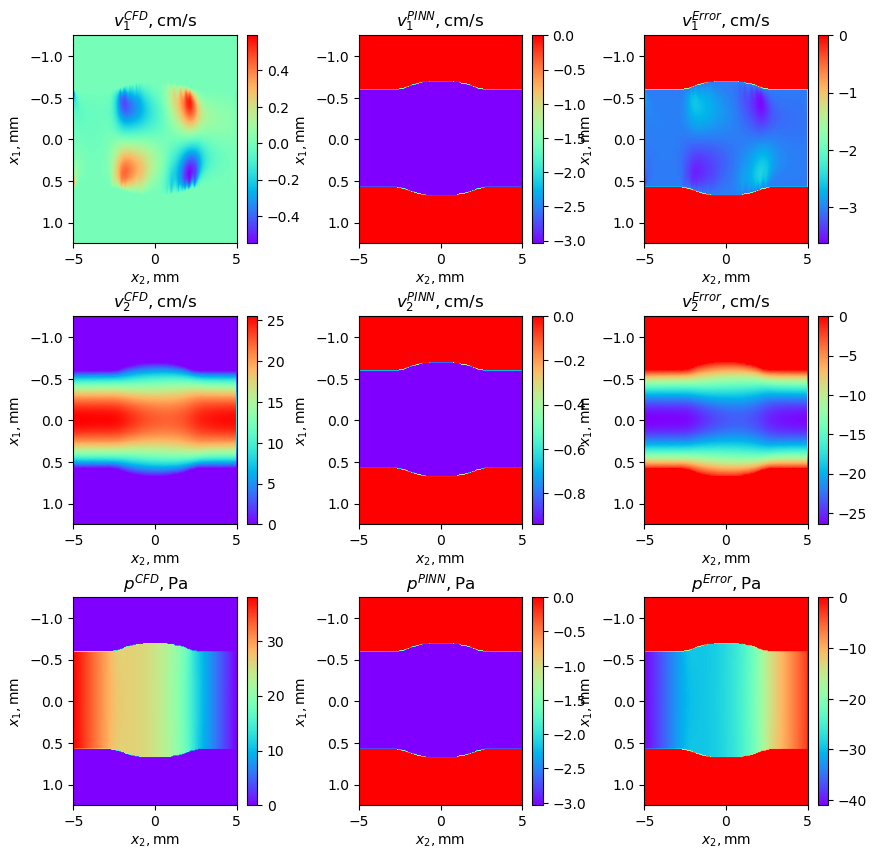

1.0 5.0 40.0
error_v 13.678653680985283 mean_error_v 80.7347471837151 v_max 28.63370000130446 error_p 32.51297374562406 mean_error_p 110.30515965260281 p_max 50.50542


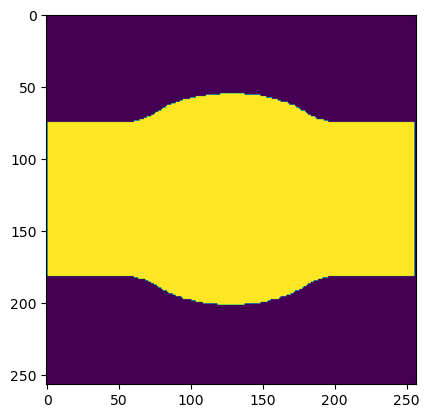

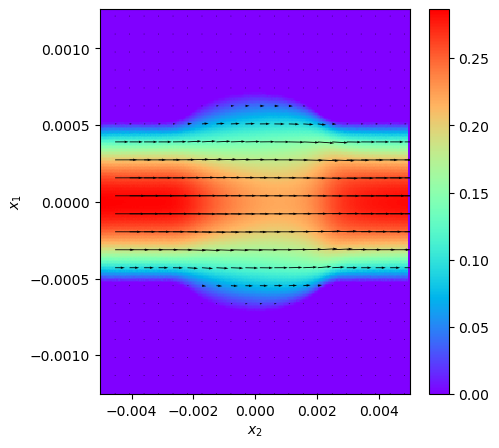

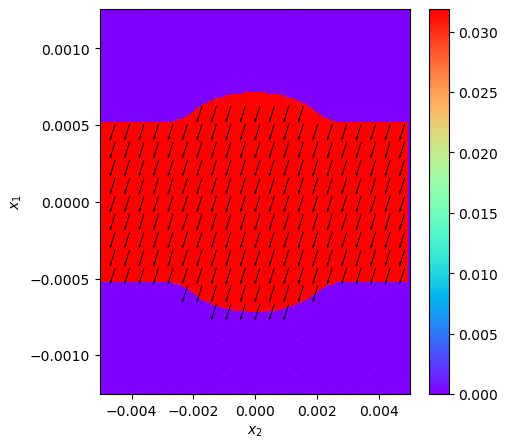

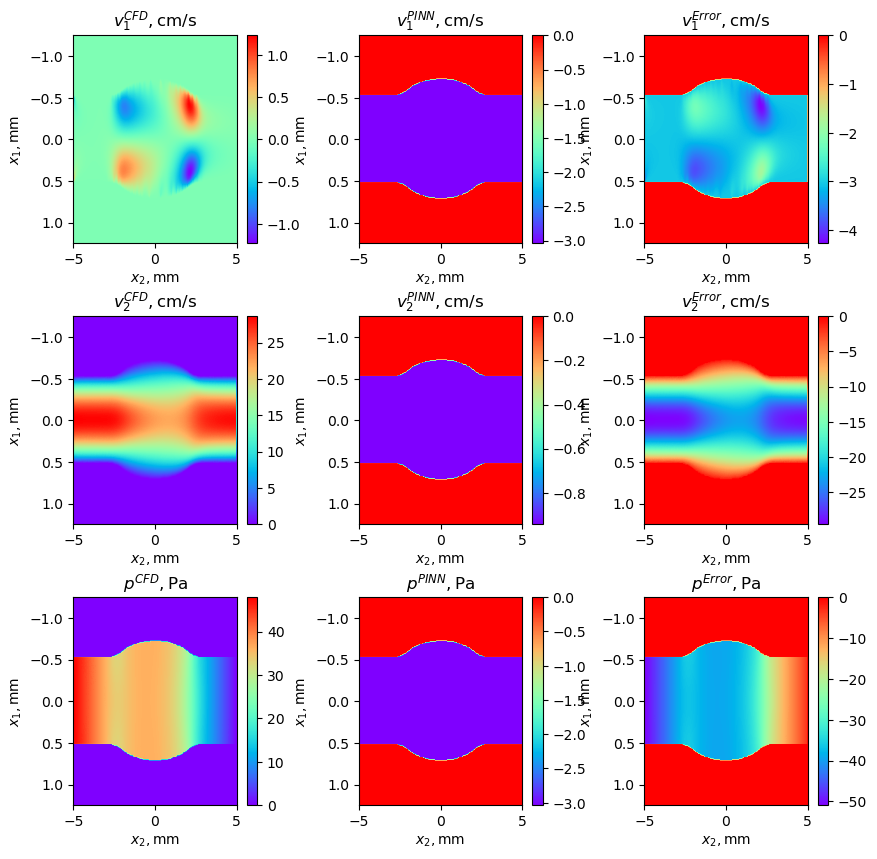

1.0 5.0 60.0
error_v 14.595087000307464 mean_error_v 81.7113378063828 v_max 32.459700000000005 error_p 45.050304763776865 mean_error_p 107.2291643331787 p_max 68.074125


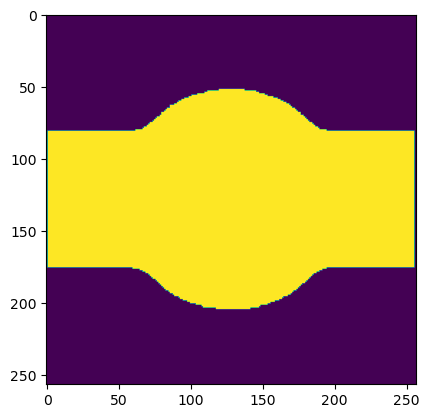

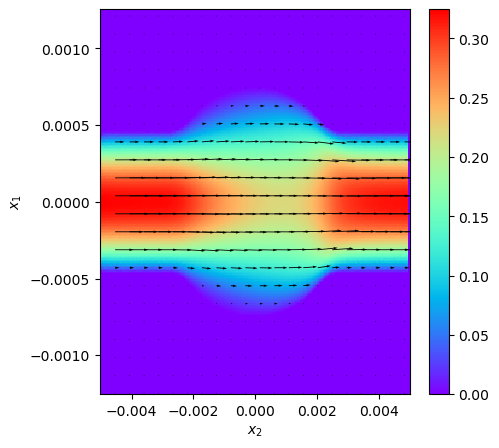

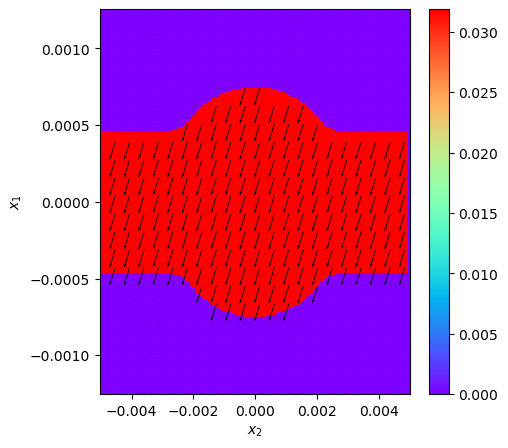

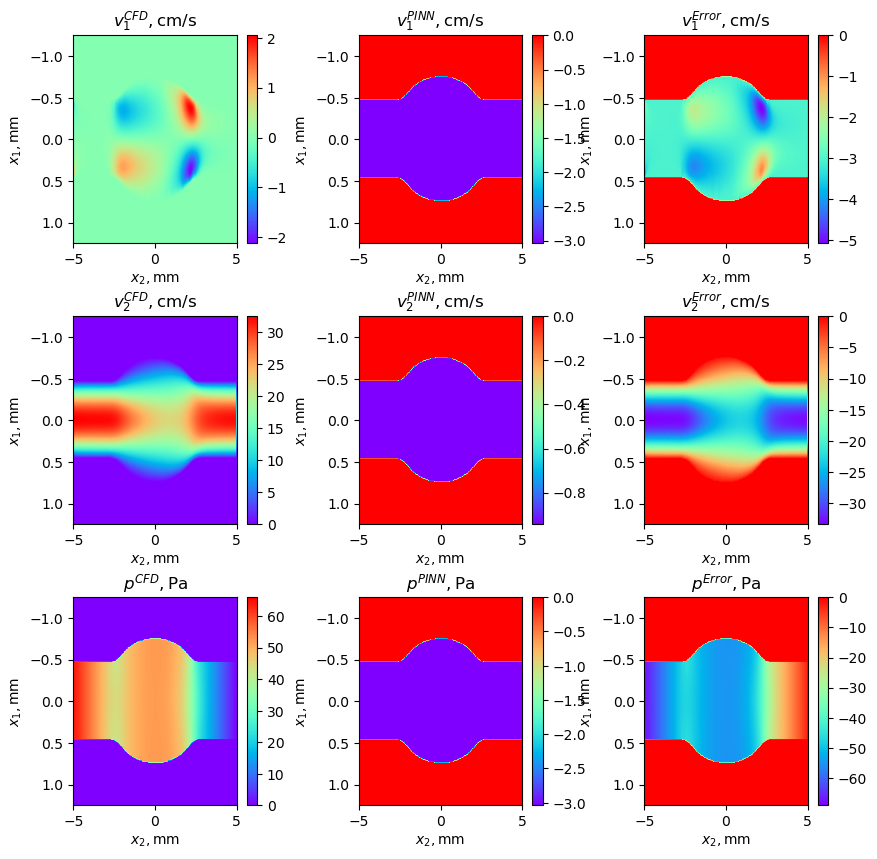

1.0 5.0 80.0
error_v 15.673591741937768 mean_error_v 82.68896216624265 v_max 38.0709 error_p 68.31689588133416 mean_error_p 104.6519011910813 p_max 98.94045


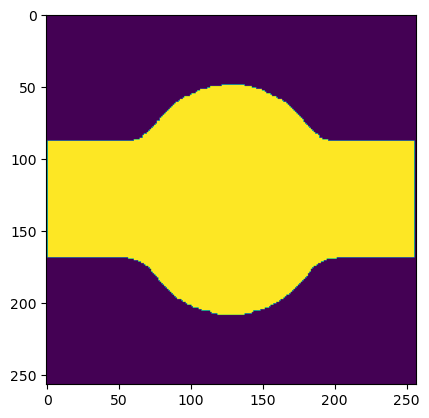

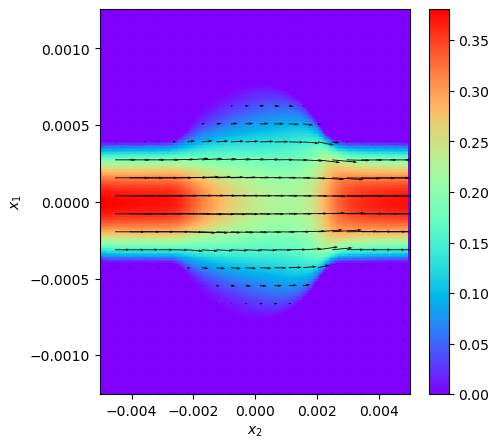

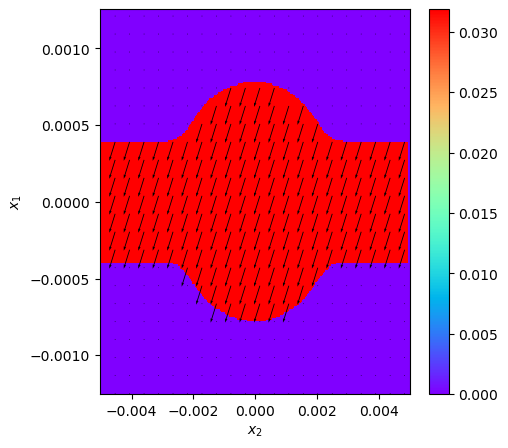

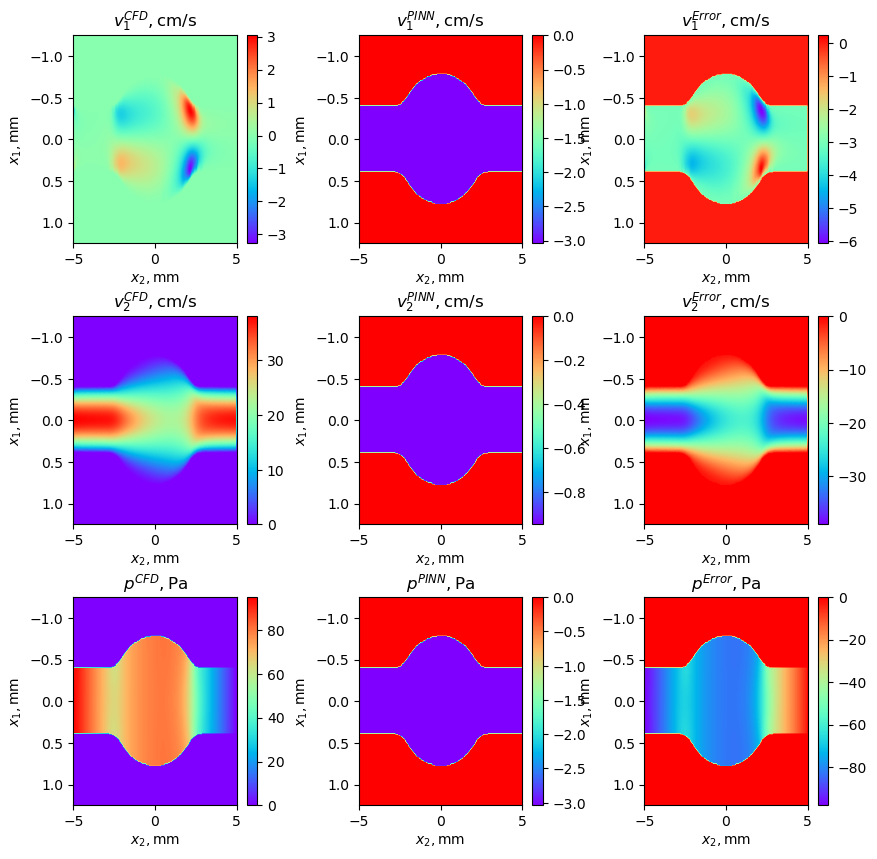

5.0 5.0 50.0
error_v 16.996318339235273 mean_error_v 83.65854422613204 v_max 45.4386 error_p 109.68609977926579 mean_error_p 102.84945503475242 p_max 160.17120000000003


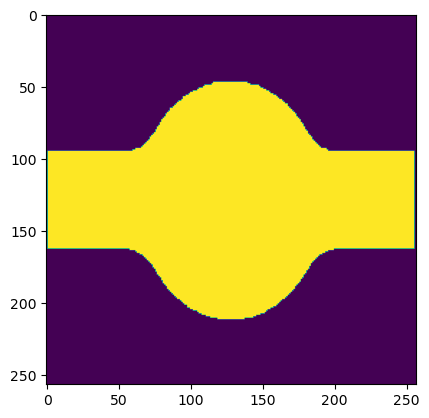

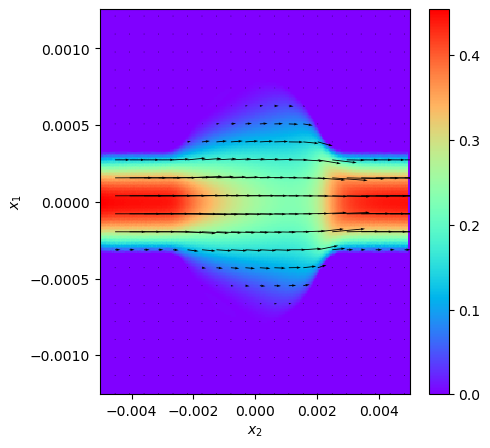

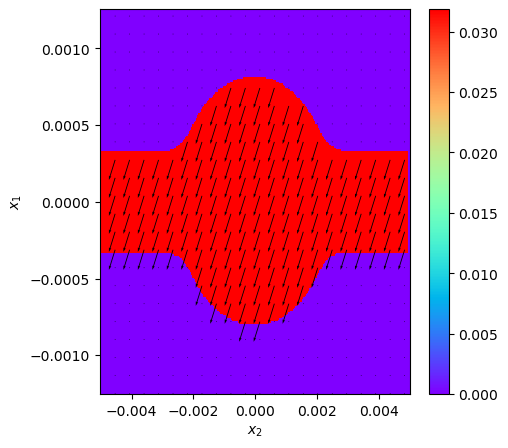

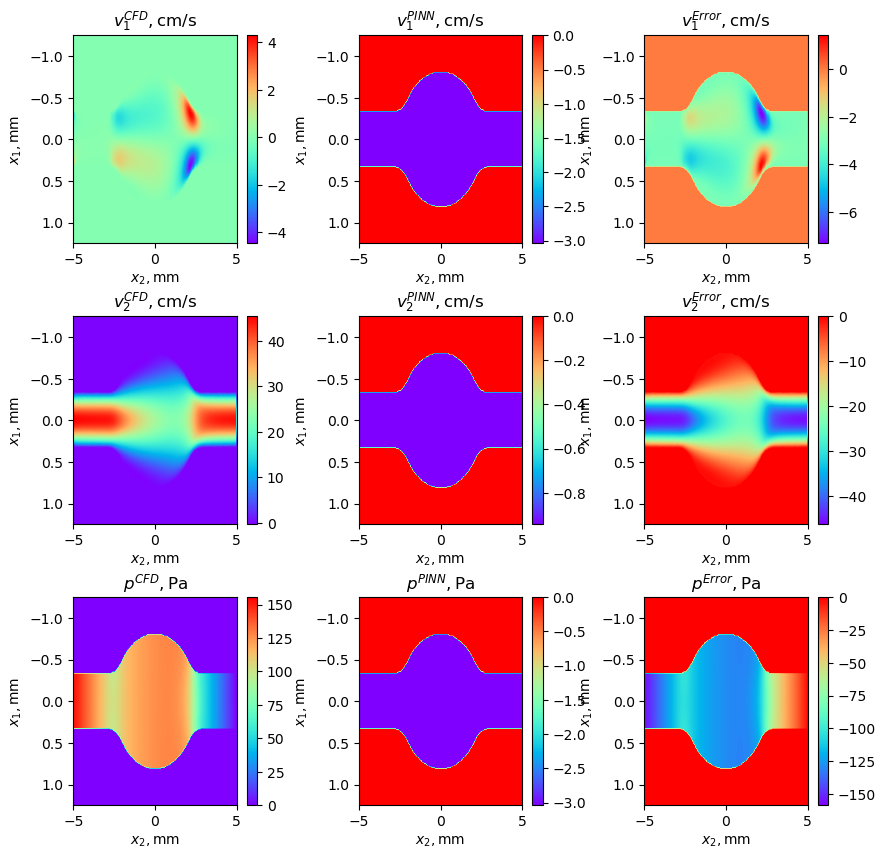

mini_val
1.0 5.0 10.0
error_v 12.469243378412765 mean_error_v 79.23788961732158 v_max 24.12230000028238 error_p 21.297644096479893 mean_error_p 116.64071266780832 p_max 36.245265


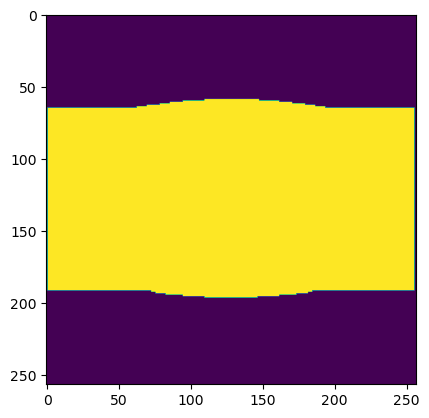

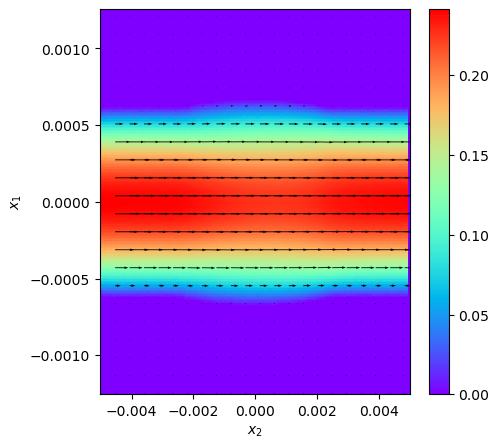

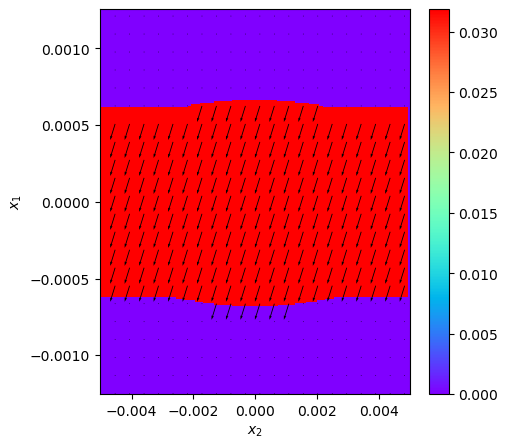

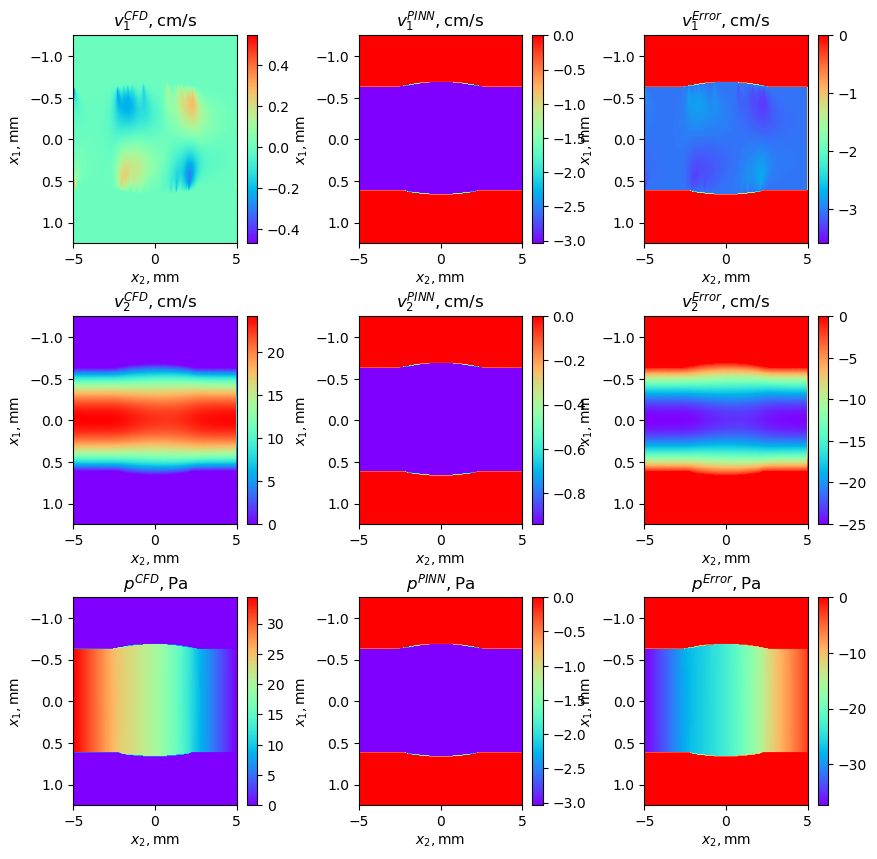

1.0 5.0 30.0
error_v 13.235986637044793 mean_error_v 80.22303623210205 v_max 26.986800487877353 error_p 27.81353634786007 mean_error_p 112.26061087183619 p_max 44.85096


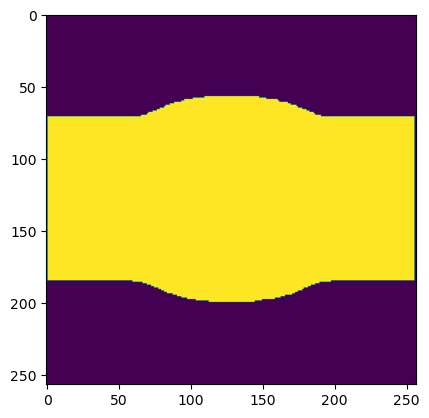

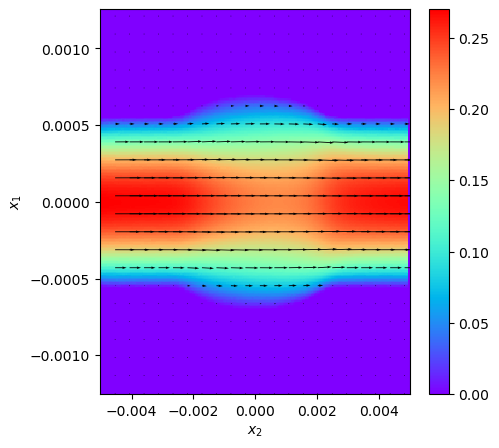

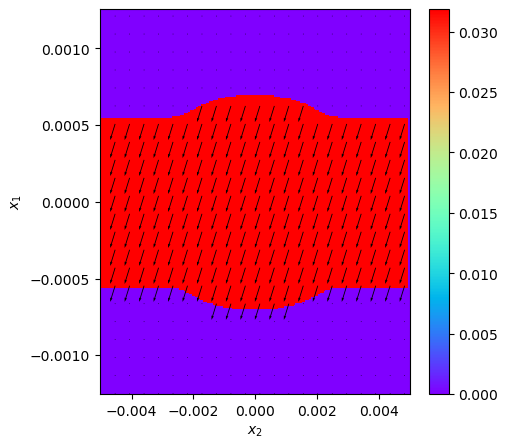

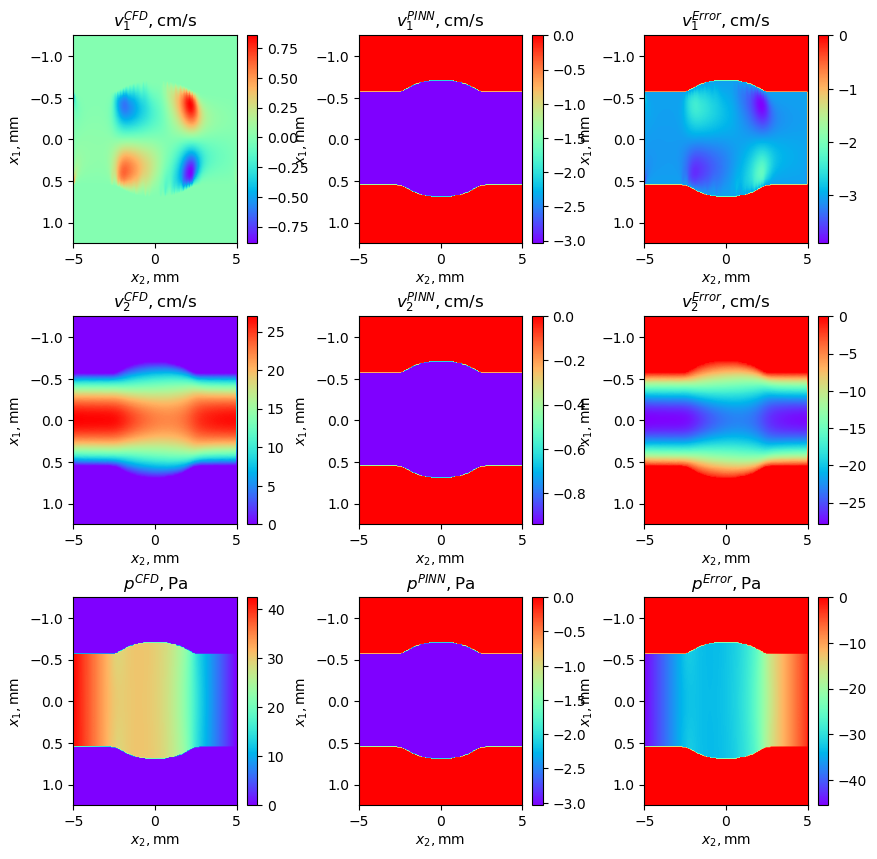

1.0 5.0 50.0
error_v 14.150585219418168 mean_error_v 81.2574992348272 v_max 30.490800019309223 error_p 38.030499189381544 mean_error_p 108.67985344015676 p_max 58.35228


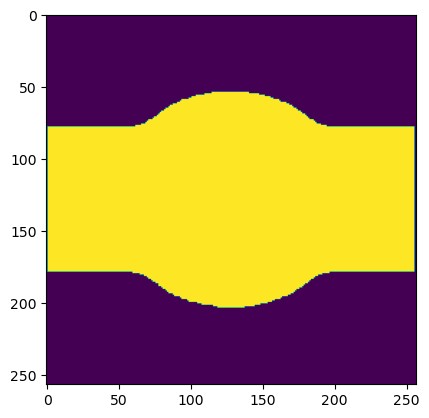

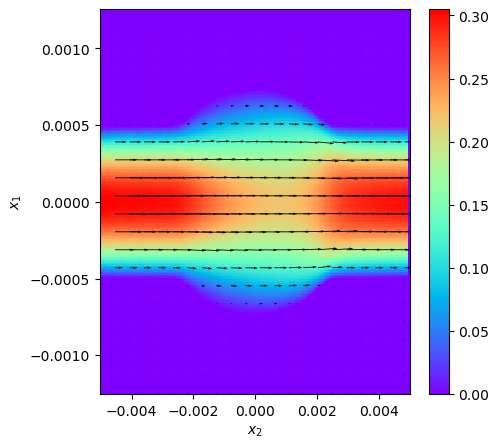

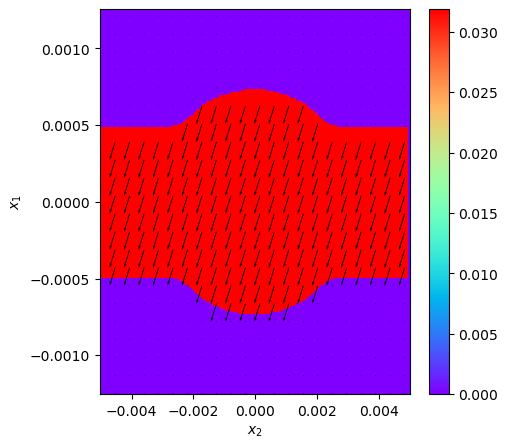

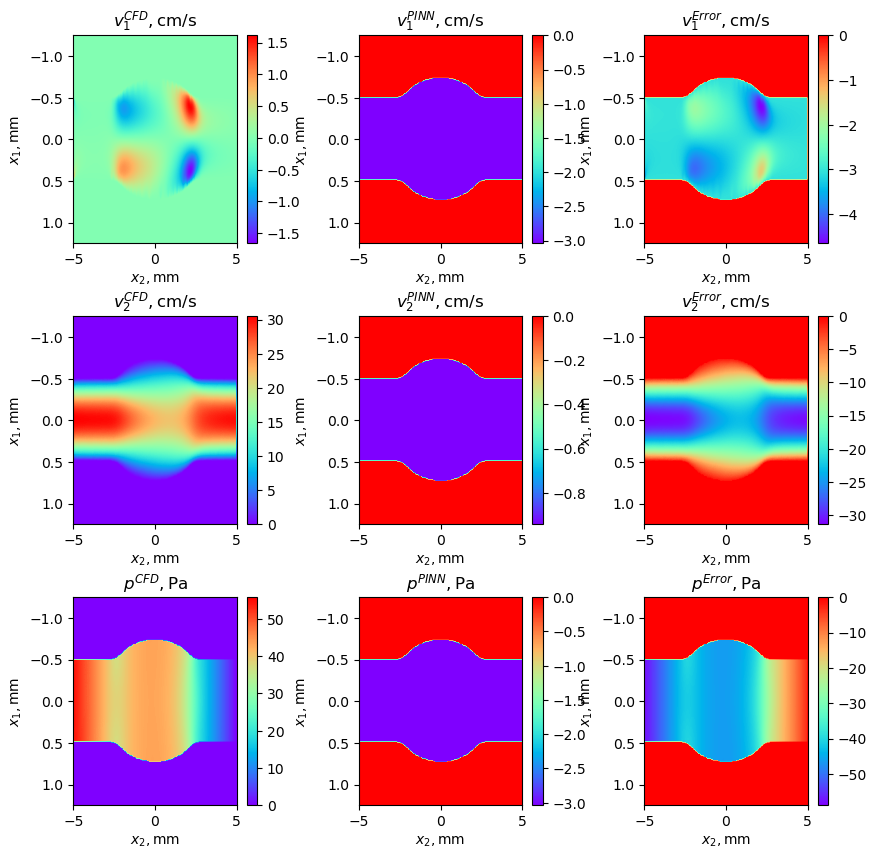

1.0 5.0 70.0
error_v 15.103316304244723 mean_error_v 82.18841622634118 v_max 35.04300004838253 error_p 55.2942294248986 mean_error_p 105.81162643473539 p_max 82.293015


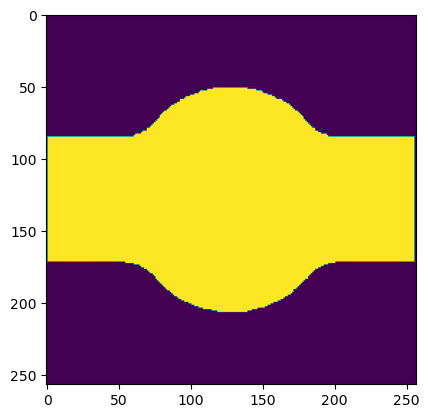

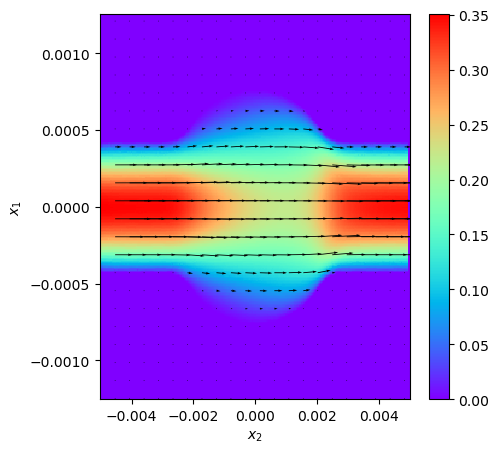

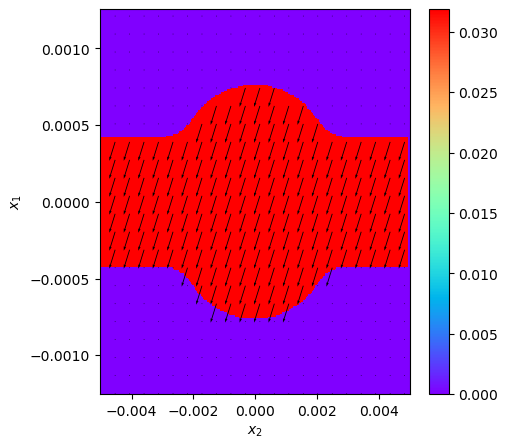

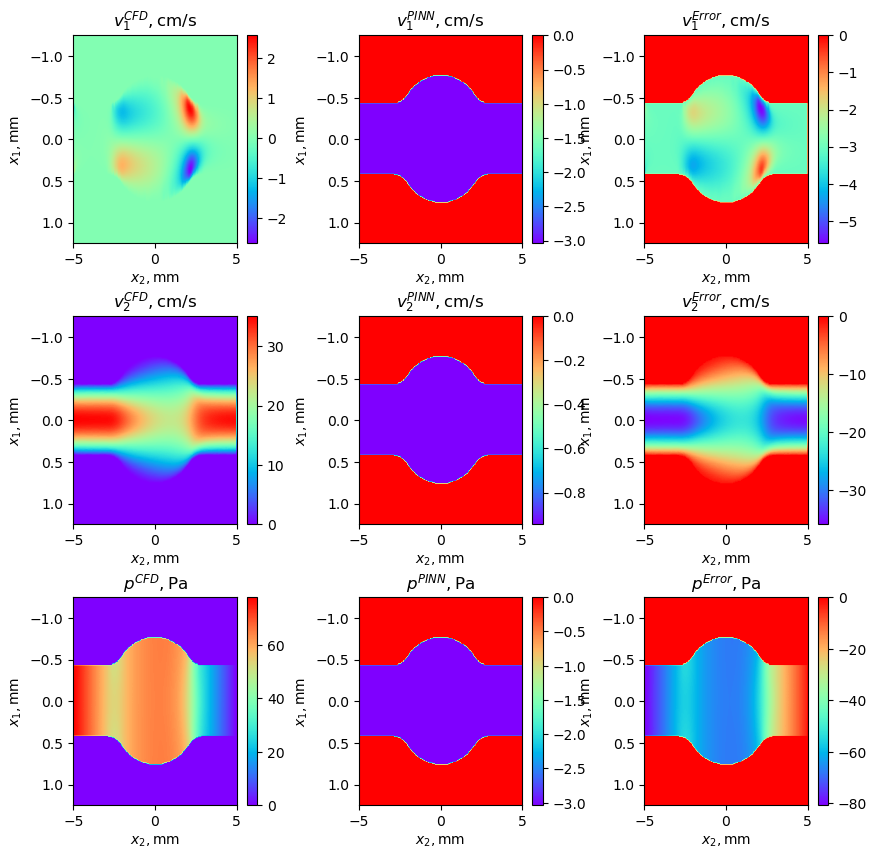

1.0 5.0 90.0
error_v 16.321017222243693 mean_error_v 83.19421091829133 v_max 41.1873 error_p 84.70442070620729 mean_error_p 103.71816574978044 p_max 125.53905


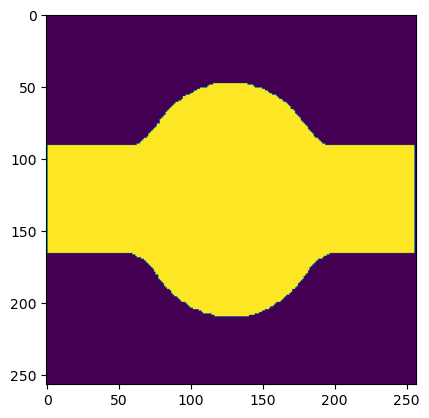

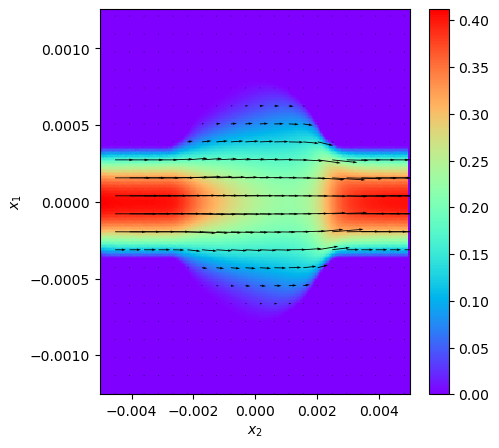

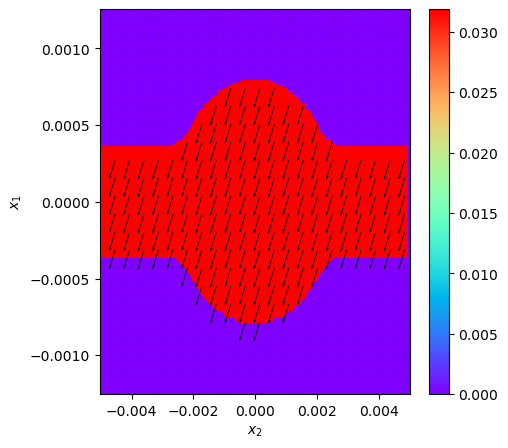

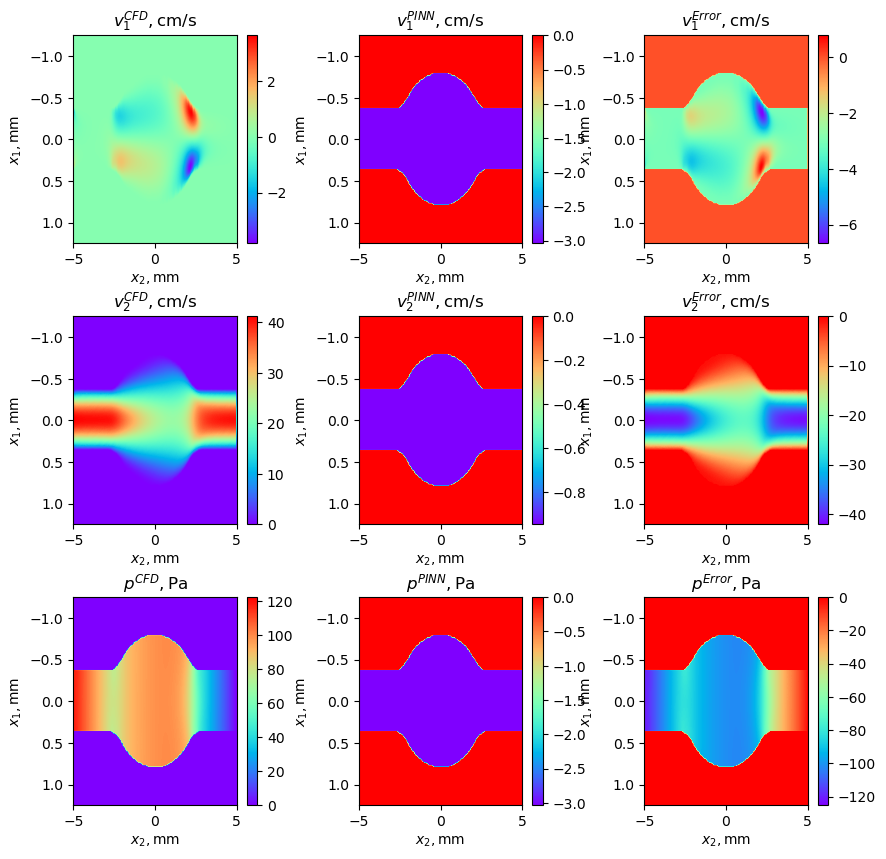

In [88]:
path = 'meshes'

with torch.no_grad():
    for i in os.listdir(path):
        print(i)
        for j in os.listdir(os.path.join(path, i)):
            if 'csv' not in j:
                continue
            df = pd.read_csv(os.path.join(path, i, j))
            p_key_1 = df.iloc[0, 0]
            p_key_2 = df.keys()[2]
            df = pd.concat(objs = (df[['Points_0', 'Points_1', p_key_2]][df['Block Name'] == p_key_1].reset_index(),
                                   df[['u_sol_0', 'u_sol_1']][df['Block Name'] == 'TimeSeries_u_sol'].reset_index()),
                                   axis=1)
            
            ind = os.listdir(os.path.join('dataset', i)).index(j.replace('csv', 'png'))

            if 'train' in i:
                mask_ = train_dataset.masks[ind][0]
            elif 'val' in i:
                mask_ = val_dataset.masks[ind][0]

            ref_1 = float(j.split('_')[1])
            ref_2 = float(j.split('_')[2])
            interp = float(j.split('_')[3][:2])
            
            inputs = df[['Points_1', 'Points_1', 'Points_0', 'Points_1', 'Points_0']].to_numpy()
            inputs[:, 0] = ref_1
            inputs[:, 1] = ref_2
            inputs[:, 2] = interp
            inputs[:, 4] -= 0.005
            targets = df[['u_sol_1', 'u_sol_0', p_key_2]].to_numpy()
            targets[:, 2] *= 1050
            outputs = model(torch.tensor(inputs).float().to(DEVICE))

            error_v, mean_error_v, v_max, error_p, mean_error_p, p_max = mae(targets, outputs.cpu().numpy()[0], inputs)
            print(ref_1, ref_2, interp)
            print('error_v', error_v, 'mean_error_v', mean_error_v, 'v_max', v_max, 'error_p', error_p, 'mean_error_p', mean_error_p, 'p_max', p_max)
            visualization_compare(ref_1, ref_2, interp, inputs[inputs[:, 3] > -0.0045], targets[inputs[:, 3] > -0.0045], outputs.cpu().numpy()[0][inputs[:, 3] > -0.0045], mask_.numpy())